# Model

In [ ]:
def AlexNet(input_shape):
    model = Sequential()
    # model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=input_shape))
    # for original Alexnet
    model.add(Conv2D(96, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    # Local Response normalization for Original Alexnet
    model.add(BatchNormalization())

    model.add(Conv2D(256, (5,5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    # determine Loss function and Optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model;

In [ ]:
model_Alex = AlexNet((64,64,3))
model_Alex.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 256)         1024      
______________________________________

#Library

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import numpy as np
import os, sys
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,LearningRateScheduler, ModelCheckpoint
import math
from keras.models import load_model, model_from_json
from keras.models import Model

Using TensorFlow backend.


# First Training

## Modify input dataset

In [ ]:
cd /content/drive/My Drive/Colab Notebooks/AlexNet (BIT)

/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)


Import image as RBG (3 dimentions matrix)

> Indented block



In [ ]:
X_list = []
for filename in sorted(os.listdir('/content/drive/My Drive/Dataset/BIT-Vehicle/BITVehicle_Dataset')):
  #print(filename)
  img = image.load_img(Path('/content/drive/My Drive/Dataset/BIT-Vehicle/BITVehicle_Dataset', filename), target_size=(64, 64))
  X_list.append(image.img_to_array(img))
X = np.array(X_list)
X.shape

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Dataset/BIT-Vehicle/VehicleInfo.csv', index_col=0)
df_dummy = pd.get_dummies(df['Vehicle_Type'])
Y = np.array(df_dummy)
Y.shape

(9850, 6)

In [ ]:
Y

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [ ]:
np.save('X',X)
np.save('Y',Y)

Load image (X) and label (Y)

In [ ]:
X = np.load('X.npy')
Y = np.load('Y.npy')
print(X.shape, Y.shape)

(9850, 64, 64, 3) (9850, 6)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(8865, 64, 64, 3) (8865, 6)
(985, 64, 64, 3) (985, 6)


## Train

In [ ]:
early_Stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1, 
    mode='auto'
)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
checkpointer = ModelCheckpoint(filepath="AlexNet.hdf5", verbose=1, save_best_only = True)
csv = CSVLogger('AlexNet.csv')

In [ ]:
history = model_Alex.fit(X_train, Y_train,
                       batch_size=256,
                       epochs=100,
                       verbose=1,
                       validation_data=(X_test, Y_test),
                       shuffle=True,
                       callbacks=[early_Stopping,reduceLR,checkpointer,csv])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8865 samples, validate on 985 samples
Epoch 1/100
8865/8865 [==============================] - 413s 47ms/step - loss: 5.4569 - acc: 0.5805 - val_loss: 3.6328 - val_acc: 0.5503

Epoch 00001: val_loss improved from inf to 3.63278, saving model to AlexNet.hdf5
Epoch 2/100
8865/8865 [==============================] - 414s 47ms/step - loss: 1.7353 - acc: 0.6197 - val_loss: 1.1677 - val_acc: 0.6629

Epoch 00002: val_loss improved from 3.63278 to 1.16767, saving model to AlexNet.hdf5
Epoch 3/100
8865/8865 [==============================] - 405s 46ms/step - loss: 0.9417 - acc: 0.7143 - val_loss: 0.9852 - val_acc: 0.6447

Epoch 00003: val_loss improved from 1.16767 to 0.98520, saving model to AlexNet.hdf5
Epoch 4/100
8865/8865 [==============================] - 403s 45ms/step - loss: 0.7851 - acc: 0.7591 - val_loss: 0.7815 - val_acc: 0.7695

Epoch 00004: val_loss improved from 0.98520 to 0.7

## Save Model

In [ ]:
model_json = model_Alex.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_Alex.save_weights("AlexNet.h5")
print("Saved model to disk")

Saved model to disk


## Testing

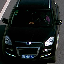

In [ ]:
img = image.load_img(Path('/content/drive/My Drive/Dataset/BIT-Vehicle/BITVehicle_Dataset', 'vehicle_0000001.jpg'))
im2array = image.img_to_array(img)
im = im2array[3:341,597:935] #Top:Bottom,Left:Right
im_final = image.array_to_img(im).resize((64,64))
im_final

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Dataset/BIT-Vehicle/VehicleInfo.csv', index_col=0)
df

,Name,Height,Width,nVehicle,Left,Top,Right,Bottom,Vehicle_Type
NaN,vehicle_0000001.jpg,1080,1920,1,597,3,935,341,SUV
NaN,vehicle_0000002.jpg,1080,1920,1,399,283,875,874,SUV
NaN,vehicle_0000003.jpg,1080,1920,1,597,97,970,538,SUV
NaN,vehicle_0000004.jpg,1080,1920,1,671,5,978,308,Sedan
NaN,vehicle_0000005.jpg,1080,1920,1,502,341,927,844,Sedan
...,...,...,...,...,...,...,...,...,...
NaN,vehicle_0009846.jpg,1200,1600,1,487,1,1250,720,Truck
NaN,vehicle_0009847.jpg,1200,1600,1,391,1,1144,751,Truck
NaN,vehicle_0009848.jpg,1200,1600,1,414,1,1155,692,Truck
NaN,vehicle_0009849.jpg,1200,1600,1,466,1,1253,717,Truck


In [ ]:
X_list = []

for index, row in df.iterrows():
  print(row['Name'])
  img = image.load_img(Path('/content/drive/My Drive/Dataset/BIT-Vehicle/BITVehicle_Dataset', row['Name']))
  im2array = image.img_to_array(img)
  im = im2array[row['Top']:row['Bottom'],row['Left']:row['Right']] #Top:Bottom,Left:Right
  im_final = image.array_to_img(im).resize((64,64))
  X_list.append(image.img_to_array(im_final))

X64 = np.array(X_list)
np.save('X64',X64)

In [ ]:
AlexNet_model = load_model('AlexNet.hdf5')

In [ ]:
inp = X[9].reshape(1,64,64,3)
predict = AlexNet_model.predict_classes(inp, batch_size=64)
predict

array([3])

In [ ]:
Y[9053]

array([0, 0, 0, 1, 0, 0], dtype=uint8)

In [ ]:
categories = ['Bus','Microbus','Minivan','SUV','Sedan','Truck']

## Diagram of result

In [ ]:
score = AlexNet_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3141881524911387
Test accuracy: 0.8923857862574195


In [ ]:
df = pd.read_csv('AlexNet.csv', index_col='epoch')
df

,acc,loss,lr,val_acc,val_loss
epoch,,,,,
0,0.580485,5.456901,0.001,0.550254,3.632785
1,0.619741,1.735321,0.001,0.662944,1.167671
2,0.714270,0.941673,0.001,0.644670,0.985200
3,0.759052,0.785122,0.001,0.769543,0.781467
4,0.794021,0.661920,0.001,0.639594,0.858275
5,0.819628,0.567089,0.001,0.672081,0.793444
6,0.841624,0.515910,0.001,0.745178,0.677417
7,0.857981,0.448916,0.001,0.858883,0.410903
8,0.881218,0.388241,0.001,0.705584,0.897910


In [ ]:
import seaborn as sns
from IPython.display import display
%matplotlib inline

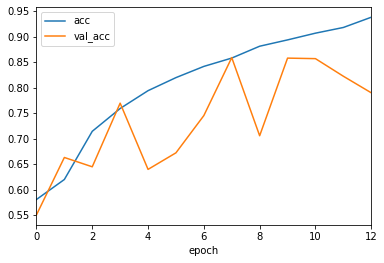

In [ ]:
display(df[['acc', 'val_acc']].plot())

In [ ]:
AlexNet_model.predict_on_batch(X[9].reshape(1,64,64,3))

array([[6.2838095e-05, 3.2801873e-03, 5.5738888e-03, 9.5238167e-01,
        3.8491223e-02, 2.1025946e-04]], dtype=float32)

## Check in dataset

In [ ]:
AlexNet_model = load_model('AlexNet.hdf5')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
inp = X[1].reshape(1,64,64,3)
predict = AlexNet_model.predict_classes(inp, batch_size=64)
predict[0]

4

In [ ]:
Y[1]

array([0, 0, 0, 1, 0, 0], dtype=uint8)

In [ ]:
np.where(Y[1] == 1)[0][0]

3

In [ ]:
X_error = []
X_i_error = []
X_true = []
X_i_true = []

for i in range(0,9850):
  inp = X[i].reshape(1,64,64,3)
  predict = AlexNet_model.predict_classes(inp, batch_size=64)
  if predict[0] != np.where(Y[i] == 1)[0][0]:
    X_error.append(X[i])
    X_i_error.append(i)
  else:
    X_true.append(X[i])
    X_i_true.append(i)

In [ ]:
np.save('X_error',X_error)
np.save('X_i_error',X_i_error)
np.save('X_true',X_true)
np.save('X_i_true',X_i_true)

## Mask RCNN

Just test, nothing can be used

In [ ]:
AlexNetJs = open('model.json', 'r')
loaded_AlexNetJs = AlexNetJs.read()
AlexNetJs.close()

In [ ]:
loaded_AlexnetModel = model_from_json(loaded_AlexNetJs)
loaded_AlexnetModel.load_weights("AlexNet.h5")

In [ ]:
cd Mask_RCNN/

/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/Mask_RCNN


In [ ]:
! python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/__init__.py to __init_

In [ ]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle

In [ ]:
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 6

In [ ]:
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())


Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
# load coco model weights
rcnn.load_weights('/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/AlexNet.h5', by_name=True)

In [ ]:
img = image.load_img('/content/drive/My Drive/Dataset/BIT-Vehicle/BITVehicle_Dataset/vehicle_0000001.jpg')
im = img.resize((640,360))
imArray = image.img_to_array(im)
results = rcnn.detect([imArray], verbose=0)
results

[{'class_ids': array([2, 1, 2], dtype=int32),
  'masks': array([[[False, False, False],
          [False, False, False],
          [False, False, False],
          ...,
          [False, False, False],
          [False, False, False],
          [False, False, False]],
  
         [[False, False, False],
          [False, False, False],
          [False, False, False],
          ...,
          [False, False, False],
          [False, False, False],
          [False, False, False]],
  
         [[False, False, False],
          [False, False, False],
          [False, False, False],
          ...,
          [False, False, False],
          [False, False, False],
          [False, False, False]],
  
         ...,
  
         [[False, False, False],
          [False, False, False],
          [False, False, False],
          ...,
          [False, False, False],
          [False, False, False],
          [False, False, False]],
  
         [[False, False, False],
          [False, False, Fa

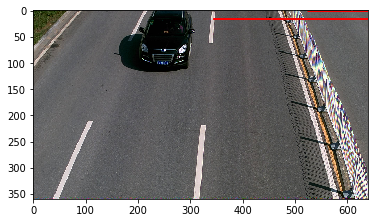

In [ ]:
draw_image_with_boxes_by_img(im, results[0]['rois'])

In [ ]:
results[0]['rois']

array([[1199, 1537, 1200, 1600],
       [1199, 1490, 1200, 1600],
       [   0,    0,    1, 1600]], dtype=int32)

In [ ]:
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()

In [ ]:
def draw_image_with_boxes_by_img(data, boxes_list):
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()

In [ ]:
!git clone https://github.com/adoval4/keras_to_OpenCV_tensorflow

Cloning into 'keras_to_OpenCV_tensorflow'...
remote: Enumerating objects: 14, done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 14
Unpacking objects: 100% (14/14), done.


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/AlexNet (BIT)

/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)


In [ ]:
from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

Using TensorFlow backend.


In [ ]:
from keras.models import load_model
model = load_weights('AlexNet.h5')

In [ ]:
model = loaded_AlexnetModel

In [ ]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])


INFO:tensorflow:Froze 151 variables.
INFO:tensorflow:Converted 151 variables to const ops.


In [ ]:
tf.train.write_graph(frozen_graph, "model", "AlexNet.pb", as_text=False)

'model/AlexNet.pb'

In [ ]:
import cv2

In [ ]:
net = cv2.dnn.readNetFromTensorflow('./model/AlexNet.pb')

In [ ]:
im = cv2.imread('/content/drive/My Drive/Dataset/BIT-Vehicle/BITVehicle_Dataset/vehicle_0000001.jpg')
(h, w) = im.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(im, (300, 300)), 0.007843, (300, 300), 127.5)

In [ ]:
net.setInput(blob)
#detections = net.forward()
net.forward()

error: ignored

# Second Training

In [ ]:
cd /content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_2

/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_2


## Making new train, test

In [ ]:
X_error = np.load('X_error.npy')
X_i_error = np.load('X_i_error.npy')
X_true = np.load('X_true.npy')
X_i_true = np.load('X_i_true.npy')

In [ ]:
X_Train = X_error
X_i_Train = X_i_error
X_Test = X_true
X_i_Test = X_i_true

In [ ]:
for i in range(0,4766):
  X_Train.append(X_Test[0])
  X_i_Train.append(X_i_Test[0])
  X_Test.pop(0)
  X_i_Test.pop(0)

In [ ]:
X_Train = np.array(X_Train)
X_i_Train = np.array(X_i_Train)
X_Test = np.array(X_Test)
X_i_Test = np.array(X_i_Test)

In [ ]:
np.save('X_Train',X_Train)
np.save('X_i_Train',X_i_Train)
np.save('X_Test',X_Test)
np.save('X_i_Test',X_i_Test)

In [ ]:
X_Train = np.load('X_Train.npy')
X_i_Train = np.load('X_i_Train.npy')
X_Test = np.load('X_Test.npy')
X_i_Test = np.load('X_i_Test.npy')
Y_Train = np.load('Y_Train.npy')
Y_Test = np.load('Y_Test.npy')

In [ ]:
Y_Train = []

for x in X_i_Train:
  Y_Train.append(Y[x])

In [ ]:
Y_Test = []
for y in X_i_Test:
  Y_Test.append(Y[y])

In [ ]:
Y_Train = np.array(Y_Train)
Y_Test = np.array(Y_Test)

In [ ]:
np.save('Y_Train',Y_Train)
np.save('Y_Test',Y_Test)

## Training

In [ ]:
filepath="./ckpt/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
early_Stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1, 
    mode='auto'
)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only = True)
csv = CSVLogger('AlexNet.csv')

In [ ]:
history = AlexNet_model.fit(X_Train, Y_Train,
                       batch_size=256,
                       epochs=100,
                       verbose=1,
                       validation_data=(X_Test, Y_Test),
                       shuffle=True,
                       callbacks=[early_Stopping,reduceLR,checkpointer,csv])

Train on 5910 samples, validate on 3940 samples
Epoch 1/100
5910/5910 [==============================] - 305s 52ms/step - loss: 0.5838 - acc: 0.8154 - val_loss: 0.1315 - val_acc: 0.9538

Epoch 00001: val_loss improved from inf to 0.13147, saving model to ./ckpt/weights-improvement-01-0.13.hdf5
Epoch 2/100
5910/5910 [==============================] - 307s 52ms/step - loss: 0.4362 - acc: 0.8624 - val_loss: 0.2369 - val_acc: 0.9391

Epoch 00002: val_loss did not improve from 0.13147
Epoch 3/100
5910/5910 [==============================] - 306s 52ms/step - loss: 0.4332 - acc: 0.8636 - val_loss: 0.1790 - val_acc: 0.9561

Epoch 00003: val_loss did not improve from 0.13147
Epoch 4/100
5910/5910 [==============================] - 307s 52ms/step - loss: 0.4051 - acc: 0.8766 - val_loss: 1.1114 - val_acc: 0.6886

Epoch 00004: val_loss did not improve from 0.13147
Epoch 5/100
5910/5910 [==============================] - 306s 52ms/step - loss: 0.4782 - acc: 0.8464 - val_loss: 0.4031 - val_acc: 0.88

In [ ]:
X_Train = np.array(X_Train)

In [ ]:
X_Train.shape

(5910, 64, 64, 3)

In [ ]:
AlexNet_model = load_model('./ckpt/weights-improvement-01-0.13.hdf5')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
score = AlexNet_model.evaluate(X_Test, Y_Test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13146711867964508
Test accuracy: 0.9538071065989848


In [ ]:
df = pd.read_csv('AlexNet.csv', index_col='epoch')
df

,acc,loss,lr,val_acc,val_loss
epoch,,,,,
0,0.815398,0.583775,0.001,0.953807,0.131467
1,0.862437,0.436224,0.001,0.939086,0.236868
2,0.863621,0.433167,0.001,0.956091,0.179010
3,0.876650,0.405105,0.001,0.688579,1.111395
4,0.846362,0.478157,0.001,0.881726,0.403133
5,0.859052,0.481036,0.001,0.950254,0.163313


In [ ]:
import seaborn as sns
from IPython.display import display
%matplotlib inline

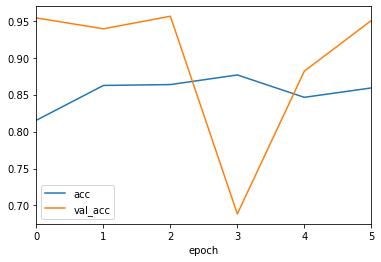

In [ ]:
display(df[['acc', 'val_acc']].plot())

## Save Model

In [ ]:
cd /content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_2

/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_2


In [ ]:
model_Alex = load_model('./ckpt/weights-improvement-01-0.13.hdf5')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
model_json = model_Alex.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_Alex.save_weights("AlexNet.h5")
print("Saved model to disk")

Saved model to disk


## Check in dataset

In [ ]:
X_error = []
X_i_error = []
X_true = []
X_i_true = []

for i in range(0,9850):
  inp = X[i].reshape(1,64,64,3)
  predict = model_Alex.predict_classes(inp, batch_size=64)
  if predict[0] != np.where(Y[i] == 1)[0][0]:
    X_error.append(X[i])
    X_i_error.append(i)
  else:
    X_true.append(X[i])
    X_i_true.append(i)

In [ ]:
len(X_error)

1074

In [ ]:
np.save('X_error',X_error)
np.save('X_i_error',X_i_error)
np.save('X_true',X_true)
np.save('X_i_true',X_i_true)

# Third Training

## Modify input training

In [ ]:
cd result_3/

/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_3


In [ ]:
X_error = np.load('X_error.npy')
X_i_error = np.load('X_i_error.npy')
X_true = np.load('X_true.npy')
X_i_true = np.load('X_i_true.npy')

In [ ]:
AlexNet_model=load_model('AlexNet.hdf5')

In [ ]:
X_Train = X_true
X_i_Train = X_i_true
X_Test = X_error
X_i_Test = X_i_error

In [ ]:
np.save('X_Train',X_Train)
np.save('X_i_Train',X_i_Train)
np.save('X_Test',X_Test)
np.save('X_i_Test',X_i_Test)

In [ ]:
Y_Train = []

for x in X_i_Train:
  Y_Train.append(Y[x])

In [ ]:
Y_Test = []
for y in X_i_Test:
  Y_Test.append(Y[y])

In [ ]:
Y_Train = np.array(Y_Train)
Y_Test = np.array(Y_Test)

In [ ]:
np.save('Y_Train',Y_Train)
np.save('Y_Test',Y_Test)

In [ ]:
filepath="./ckpt/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
early_Stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1, 
    mode='auto'
)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only = True)
csv = CSVLogger('AlexNet.csv')

In [ ]:
history = AlexNet_model.fit(X_Train, Y_Train,
                       batch_size=8,
                       epochs=100,
                       verbose=1,
                       validation_data=(X_Test, Y_Test),
                       shuffle=True,
                       callbacks=[early_Stopping,reduceLR,checkpointer,csv])

Train on 8706 samples, validate on 1144 samples
Epoch 1/100
8706/8706 [==============================] - 903s 104ms/step - loss: 1.6274 - acc: 0.6807 - val_loss: 6.3163 - val_acc: 0.2299

Epoch 00001: val_loss improved from 6.38614 to 6.31627, saving model to ./ckpt/weights-improvement-01-6.32.hdf5
Epoch 2/100
8706/8706 [==============================] - 882s 101ms/step - loss: 1.6357 - acc: 0.6941 - val_loss: 7.6663 - val_acc: 0.2544

Epoch 00002: val_loss did not improve from 6.31627
Epoch 3/100
8706/8706 [==============================] - 869s 100ms/step - loss: 1.4715 - acc: 0.7456 - val_loss: 7.2968 - val_acc: 0.2133

Epoch 00003: val_loss did not improve from 6.31627
Epoch 4/100
8706/8706 [==============================] - 891s 102ms/step - loss: 1.4323 - acc: 0.7749 - val_loss: 8.0879 - val_acc: 0.2902

Epoch 00004: val_loss did not improve from 6.31627
Epoch 5/100
8706/8706 [==============================] - 883s 101ms/step - loss: 1.2471 - acc: 0.8124 - val_loss: 8.3750 - val_

# SVM

In [ ]:
cd "/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)"

/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)


In [1]:
model_path = "/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_2"

In [4]:
AlexNet_model = load_model(Path(model_path,'ckpt/weights-improvement-01-0.13.hdf5')) #Result 2

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [8]:
# save_folder = "/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)"
# # Save model architecture
# model_json = AlexNet_model.to_json()
# with open(os.path.join(save_folder,"model.json"), "w") as json_file:
#   json_file.write(model_json)
# # Save model weight
# AlexNet_model.save_weights(os.path.join(save_folder,'model_weight.h5'))

In [ ]:
AlexNet_model.layers

In [ ]:
X_train = np.load('/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_2/X_Train.npy')
X_test = np.load('/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_2/X_Test.npy')
Y_train = np.load('/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_2/Y_Train.npy')
Y_test = np.load('/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_2/Y_Test.npy')

In [ ]:
model_extract_feature = Model(AlexNet_model.input, AlexNet_model.get_layer(AlexNet_model.layers[9].name).output)

In [ ]:
X_train_feats = model_extract_feature.predict(X_train)
X_test_feats = model_extract_feature.predict(X_test)

In [ ]:
X_train_feats = [X_train_feats[i].flatten() for i in range(len(X_train_feats))]
X_test_feats = [X_test_feats[i].flatten() for i in range(len(X_test_feats))]

In [ ]:
# np.save('/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_3/SVM/X_train_features.npy',X_train_feats)
# np.save('/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_3/SVM/X_test_features.npy',X_test_feats)

In [ ]:
# X_train_feats = np.load('/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_3/SVM/X_train_features.npy')
# X_test_feats = np.load('/content/drive/My Drive/Colab Notebooks/AlexNet (BIT)/result_3/SVM/X_test_features.npy')

In [ ]:
# get extracted feature

In [ ]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

In [ ]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'],
                'gamma': [1e-3, 1e-4],
                'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
#{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}

In [ ]:
Y_train_labels = [np.argmax(Y_train[i]) for i in range(len(Y_train))]
Y_test_labels = [np.argmax(Y_test[i]) for i in range(len(Y_test))]

In [ ]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_feats, Y_train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
final_model = svm_model.best_estimator_

In [ ]:
Y_pred = final_model.predict(X_test_feats)

In [ ]:
accuracy_score(Y_test_labels,Y_pred)

0.9131979695431472